# Modèle RandomForest et Bagging

Dans ce notebook, je vais tester les modèles de classification Random Forest et Bagging.

Pour cela, il va falloir:
- nettoyer les données
- les grouper par jour afin de supprimer les variations de production horaires
- découper en classe la variable `total_prod`



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import feather
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Charge le fichier feather
df = pd.read_feather('data/energy_clean.ftr')


In [2]:
df = df.drop(columns=['date_heure'])

In [3]:
df = df.groupby(['annee', 'mois', 'jour'])[['total_prod']].sum().reset_index()

In [4]:
df.total_prod = df.total_prod.astype(int)

In [5]:
n = 10
# Découpe en n parts
deciles = np.linspace(0, 1, n+1)
labels = np.linspace(0, n-1, n)
df['prod_class'] = pd.qcut(df.total_prod, q=deciles, labels=labels).astype(int)

In [6]:
df.head()

,annee,mois,jour,total_prod,prod_class
0,2013,1,1,3025248,6
1,2013,1,2,3421668,8
2,2013,1,3,3473171,8
3,2013,1,4,3419065,8
4,2013,1,5,3266765,7


# I - Modélisation de RandomForest

- `data`: contient les variables explicatives *annee*, *mois* et *jour*
- `target`: variable expliquée *prod_class*

## I.1 = GridSearchCV
**GridSearchCV** permet de trouver les meilleurs hyper-paramètres pour le modèle RandomForest

In [7]:
data = df.drop(columns=['total_prod', 'prod_class'])
target = df.prod_class

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.25, random_state=123)


In [8]:
# Deéfinition des paramètres
param_grid = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
               'min_samples_leaf': [1, 3, 5],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [2, 4, 8, 16]
              }]

# Création de GridSearchCV
dfrst = RandomForestClassifier()
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(X_train, y_train)
# Récupère le meilleur estimateur
clf = grid_results.best_estimator_
# Prédiction sur le jeu de test
y_pred = clf.predict(X_test)


In [9]:
print('Accuracy:', round(accuracy_score(y_test, y_pred), 4))

Accuracy: 0.4268


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51        68
           1       0.25      0.22      0.24        86
           2       0.24      0.20      0.21        82
           3       0.24      0.30      0.27        69
           4       0.32      0.32      0.32        73
           5       0.51      0.56      0.54        68
           6       0.54      0.52      0.53        69
           7       0.49      0.46      0.48        69
           8       0.45      0.47      0.46        75
           9       0.74      0.79      0.77        72

    accuracy                           0.43       731
   macro avg       0.43      0.44      0.43       731
weighted avg       0.42      0.43      0.42       731



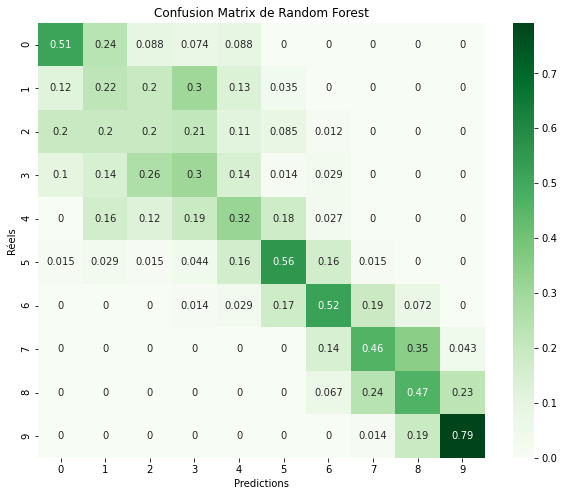

In [17]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix, annot=True, cmap=plt.cm.Greens)

ax.set_xlabel('Predictions')
ax.set_ylabel('Réels')
ax.set_title('Confusion Matrix de Random Forest')

plt.savefig("Outputs/02_-_Matrice_RFC.png", dpi=150, bbox_inches='tight')

plt.show()

## I.2 - Interprétation du modèle Random Forest

Le score Accuracy n'est pas très bon mais cela est assez prévisible.

La matrice de confusion indique qu'il n'y a globalement pas beaucoup de prédiction abbérantes.

Les classes supérieures semblent plus facilement prédictibles alors que les classes inférieures, hormis la 0, ont des scores faibles. Cela est du à l'étendue intra-classe qui n'est pas la même suivant les classes, comme l'indique le code ci-dessous.

In [12]:
for i, v in enumerate( sorted(df.prod_class.unique()) ):
    class_min = df[df.prod_class == v]['total_prod'].min()
    class_max = df[df.prod_class == v]['total_prod'].max()
    etendue = class_max - class_min
    print('Etendue class ', v, ':', etendue)

Etendue class  0 : 523758
Etendue class  1 : 149967
Etendue class  2 : 115207
Etendue class  3 : 92453
Etendue class  4 : 87446
Etendue class  5 : 167443
Etendue class  6 : 222738
Etendue class  7 : 208379
Etendue class  8 : 212144
Etendue class  9 : 591192


# II  - Modélisation de Bagging

In [13]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(base_estimator=clf)
bc.fit(X_train, y_train)

bc_pred = bc.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, bc_pred), 4))

Accuracy: 0.4364


In [14]:
print(classification_report(y_test, bc_pred))

              precision    recall  f1-score   support

           0       0.50      0.53      0.51        68
           1       0.26      0.21      0.23        86
           2       0.22      0.20      0.21        82
           3       0.31      0.38      0.34        69
           4       0.33      0.29      0.31        73
           5       0.47      0.54      0.51        68
           6       0.49      0.52      0.51        69
           7       0.50      0.43      0.47        69
           8       0.53      0.53      0.53        75
           9       0.70      0.82      0.76        72

    accuracy                           0.44       731
   macro avg       0.43      0.45      0.44       731
weighted avg       0.43      0.44      0.43       731



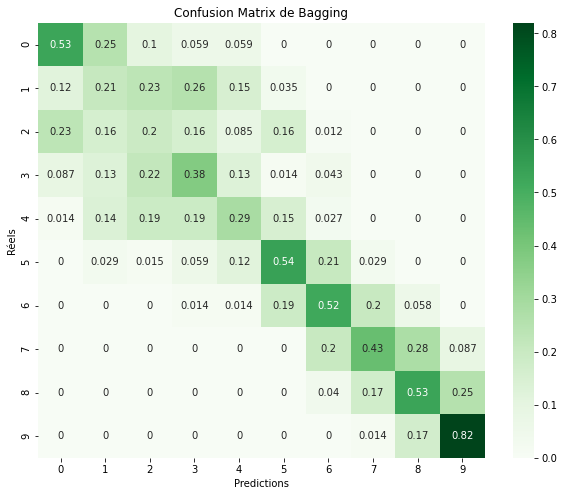

In [15]:
matrix = confusion_matrix(y_test, bc_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, cmap=plt.cm.Greens)

plt.xlabel('Predictions')
plt.ylabel('Réels')
plt.title('Confusion Matrix de Bagging')
plt.show()

## Interprétation du modèle Bagging

Le score Accuracy est similaire.

Les conclusions sont les mêmes que pour le modèle RandomForest.

Il faudrait donc découper les la production en classes de même étendue afin de palier à ce problème.